In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastai.vision.models.xresnet import *
from fastai.vision.models.unet import DynamicUnet
from bpho import *

/home/fredmonroe/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
torch.cuda.set_device(1)

In [3]:
datasetname = 'combo_001'
data_path = Path('.')
datasets = data_path/'datasets'
datasources = data_path/'data'
dataset = datasets/datasetname

test_files = dataset/'test'
hr_tifs = dataset/'hr'
lr_tifs = dataset/'lr'
lr_up_tifs = dataset/'lr_up'

mname = 'combo'
model_dir = 'models'

loss = F.mse_loss
metrics = sr_metrics

In [7]:
def get_src(x_data, y_data_):
    def map_to_hr(x):
        hr_name = x.relative_to(x_data)
        return y_data_/hr_name
    src = (ImageImageList
            .from_folder(x_data, convert_mode='L')
            .split_by_rand_pct()
            .label_from_func(map_to_hr, convert_mode='L'))
    return src


def get_data(bs, size, x_data, y_data, max_zoom=1.1, **kwargs):
    src = get_src(x_data, y_data)
    tfms = get_transforms(flip_vert=True, max_zoom=max_zoom)
    data = (src
            .transform(tfms, size=size)
            .transform_y(tfms, size=size)
            .databunch(bs=bs,**kwargs))
    data.c = 3
    return data

def do_fit(learn, save_name, lrs=slice(1e-3), pct_start=0.9, cycle_len=10):
    learn.to_fp16().fit_one_cycle(cycle_len, lrs, pct_start=pct_start)
    learn.save(save_name)
    print(f'saved: {save_name}')
    num_rows = min(learn.data.batch_size, 3)
    learn.to_fp32().show_results(rows=num_rows, imgsize=5)

In [ ]:
if False:
    learn.lr_find()
    learn.recorder.plot()

In [ ]:
step = 0
lr = 1e-3
cycles = 2
loss = F.mse_loss
metrics = sr_metrics


bs = 16
size = 256
max_zoom = 6
arch = xresnet34

data = get_data(bs, size, lr_up_tifs, hr_tifs, max_zoom=max_zoom)
learn = xres_unet_learner(data, arch, loss_func=loss, metrics=metrics, model_dir=model_dir)
gc.collect()

In [ ]:
do_fit(learn, f'{mname}.{step:02d}', lrs=lr, cycle_len=cycles)

In [6]:
step = 1
lr = 1e-4
cycles = 2
loss = F.mse_loss
metrics = sr_metrics


bs = 12
size = 512
max_zoom = 4
arch = xresnet34

data = get_data(bs, size, lr_up_tifs, hr_tifs, max_zoom=max_zoom)
learn = xres_unet_learner(data, arch, loss_func=loss, metrics=metrics, model_dir=model_dir)
learn.load(f'{mname}.{(step-1):02d}')
gc.collect()

0

epoch,train_loss,valid_loss,ssim,psnr,time
0,0.001450,0.001112,0.777433,31.647108,20:50
1,0.001768,0.001130,0.838825,31.561350,19:59


saved: combo.01


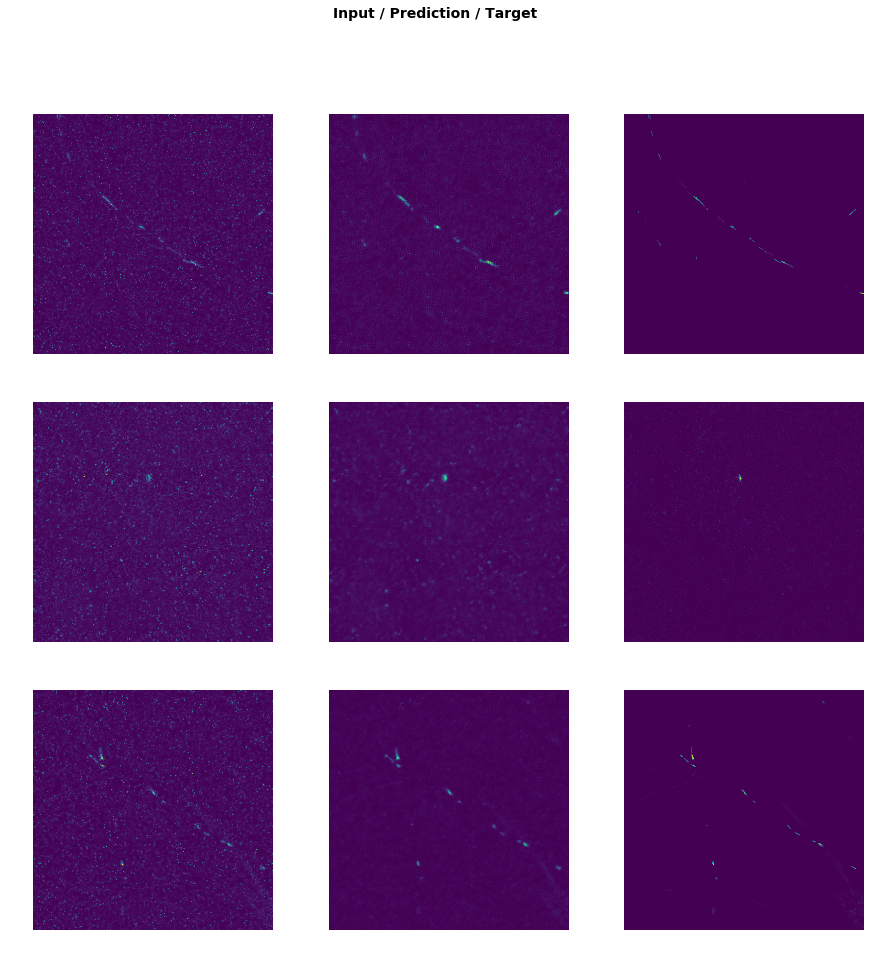

In [8]:
do_fit(learn, f'{mname}.{step:02d}', lrs=lr, cycle_len=cycles)

epoch,train_loss,valid_loss,ssim,psnr,time
0,0.001359,0.001129,0.842326,31.567984,21:12
1,0.001509,0.001124,0.844999,31.598843,21:01
2,0.001309,0.001121,0.850457,31.628256,20:51
3,0.001313,0.001108,0.852721,31.718241,20:09
4,0.001253,0.001102,0.855386,31.765188,21:32
5,0.001604,0.001095,0.859602,31.833231,19:44
6,0.001648,0.001093,0.861974,31.863886,21:28
7,0.001317,0.001097,0.867912,31.864143,21:15
8,0.001714,0.001099,0.861972,31.817219,20:43
9,0.001548,0.001098,0.864504,31.826796,21:32


saved: combo.01


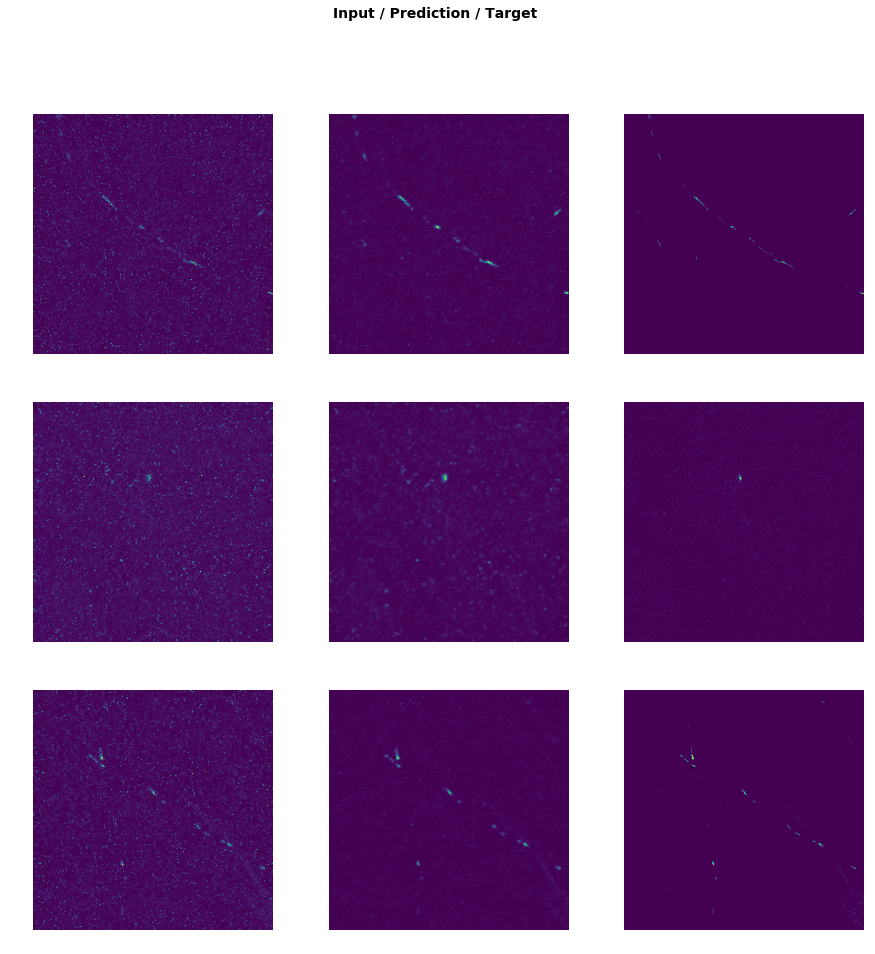

In [9]:
do_fit(learn, f'{mname}.{step:02d}', lrs=lr/50, cycle_len=cycles*5)

In [5]:
step = 2
lr = 1e-4
cycles = 2
loss = F.mse_loss
metrics = sr_metrics


bs = 2
size = 1024
max_zoom = 2
arch = xresnet34

data = get_data(bs, size, lr_up_tifs, hr_tifs, max_zoom=max_zoom, num_workers=4)
learn = xres_unet_learner(data, arch, loss_func=loss, metrics=metrics, model_dir=model_dir)
learn.load(f'{mname}.{(step-1):02d}')
gc.collect()

0

In [ ]:
do_fit(learn, f'{mname}.{step:02d}', lrs=lr, cycle_len=cycles)

In [ ]:
do_fit(learn, f'{mname}.{step:02d}.1', lrs=lr/50, cycle_len=cycles*5)

In [10]:
test_fns = []
test_fns += list(datasources.glob('**/test/*.tif'))
test_fns += list(datasources.glob('**/test/*.czi'))

In [11]:
len(test_fns)

54

In [12]:
#test_fns = []
#test_fns += list(test_files.glob('**/*.tif'))
#test_fns += list(test_files.glob('**/*.czi'))

In [ ]:
step = 1
lr = 1e-4
cycles = 2
loss = F.mse_loss
metrics = sr_metrics


bs = 1
size = 440*4
max_zoom = 2
arch = xresnet34

data = get_data(bs, size, lr_up_tifs, hr_tifs, max_zoom=max_zoom)
learn = xres_unet_learner(data, arch, loss_func=loss, metrics=metrics, model_dir=model_dir)
learn.load(f'{mname}.{step:02d}').to_fp16()
gc.collect()

In [ ]:
dest = Path('/DATA/Dropbox/bpho_movie_results/combo_xres_unet/')
dest.mkdir(exist_ok=True, parents=True)
generate_tifs(test_fns, dest, learn, size, tag=mname, max_imgs=10)

In [ ]:
#%debug